# Outlier detection in SMACOF solutions

In [1]:
from scripts.ClusterTS_MDS import ClusterVTECDataMDS

import numpy as np
from matplotlib.pyplot import subplots
from matplotlib import rcParams
from sklearn.cluster import HDBSCAN
from sklearn.metrics.cluster import calinski_harabasz_score, davies_bouldin_score

rcParams.update({
    "text.usetex": True
})

In [2]:
PTEX_dissim = np.loadtxt("./data/PTEX_DTW_matrix.dat", dtype= np.float64, delimiter = ",")
PTEX_dissim.shape

(4339, 4339)

SMACOF-Dissim with 2 components has a stress value of 0.113658


0.1136584352157547

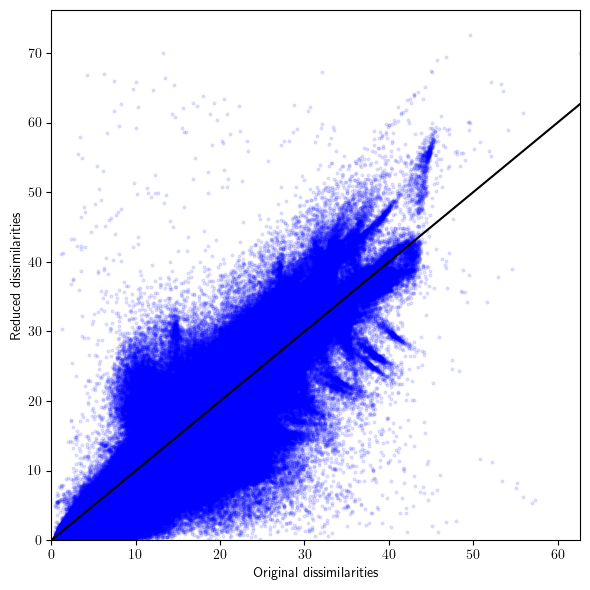

In [3]:
TEC_ClusterSeries = ClusterVTECDataMDS(dissimilarity = PTEX_dissim)
TEC_ClusterSeries.ComputeMDS(num_comps_mds = 2, method = "SMACOF-Dissim")

## Outlier detection using HDBSCAN

In [ ]:
min_cluster_size_list = tuple(range(5, 55, 5))
CH_cluster_scores =[0]*len(min_cluster_size_list)
DB_cluster_scores =[0]*len(min_cluster_size_list)
number_found_clusters = [0]*len(min_cluster_size_list)

for k, num_samples in enumerate(min_cluster_size_list):
    HDBSCAN_Out = HDBSCAN(min_cluster_size = num_samples).fit(TEC_ClusterSeries.Xc_TS)
    CH_cluster_scores[k] = calinski_harabasz_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
    DB_cluster_scores[k] = davies_bouldin_score(TEC_ClusterSeries.Xc_TS, HDBSCAN_Out.labels_)
    number_found_clusters[k] = len(np.unique(HDBSCAN_Out.labels_))

maximum_CH_index = np.argmax(CH_cluster_scores)
minimum_DB_index = np.argmin(DB_cluster_scores)
print("Optimal number of neighbours by CH score: ", min_cluster_size_list[maximum_CH_index])
print("Number of clusters given by maximum CH score: ", number_found_clusters[maximum_CH_index])
print("Optimal number of neighbours by DB score: ", min_cluster_size_list[minimum_DB_index])
print("Number of clusters given by minimum CH score: ", number_found_clusters[minimum_DB_index])

Optimal number of neighbours by CH score:  25
Number of clusters given by maximum CH score:  4
Optimal number of neighbours by DB score:  25
Number of clusters given by minimum CH score:  4


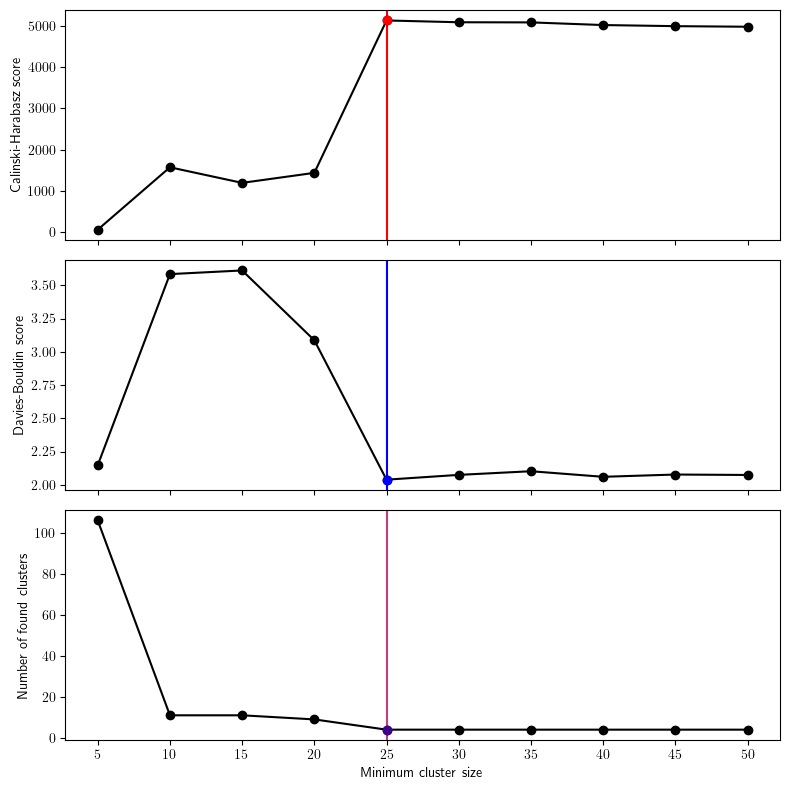

In [5]:
Figure, Subplot = subplots(3, 1, figsize = (8, 8), sharex = "col")

Subplot[0].axvline(min_cluster_size_list[maximum_CH_index], color = "red", zorder = 0)
Subplot[0].plot(min_cluster_size_list, CH_cluster_scores, "-ok", zorder = 1)
Subplot[0].scatter(min_cluster_size_list[maximum_CH_index], CH_cluster_scores[maximum_CH_index], c = "red", marker = "o", zorder = 2)

Subplot[1].axvline(min_cluster_size_list[minimum_DB_index], color = "blue", zorder = 0)
Subplot[1].plot(min_cluster_size_list, DB_cluster_scores, "-ok", zorder = 1)
Subplot[1].scatter(min_cluster_size_list[minimum_DB_index], DB_cluster_scores[minimum_DB_index], c = "blue", marker = "o", zorder = 2)

Subplot[2].axvline(min_cluster_size_list[minimum_DB_index], color = "blue", zorder = 0, alpha = 0.5)
Subplot[2].axvline(min_cluster_size_list[maximum_CH_index], color = "red", zorder = 0, alpha = 0.5)
Subplot[2].plot(min_cluster_size_list, number_found_clusters, "-ok", zorder = 1)
Subplot[2].scatter(min_cluster_size_list[maximum_CH_index], number_found_clusters[maximum_CH_index], c = "red", marker = "o", zorder = 2, alpha = 0.5)
Subplot[2].scatter(min_cluster_size_list[minimum_DB_index], number_found_clusters[minimum_DB_index], c = "blue", marker = "o", zorder = 2, alpha = 0.5)


Subplot[0].set_ylabel("Calinski-Harabasz score")
Subplot[1].set_ylabel("Davies-Bouldin score")
Subplot[2].set_ylabel("Number of found clusters")
Subplot[2].set_xlabel("Minimum cluster size")
Subplot[2].set_xticks(min_cluster_size_list)

Figure.tight_layout()

Size for minimum cluster:  25
Counter({0: 2387, 1: 1115, 2: 538, -1: 299})


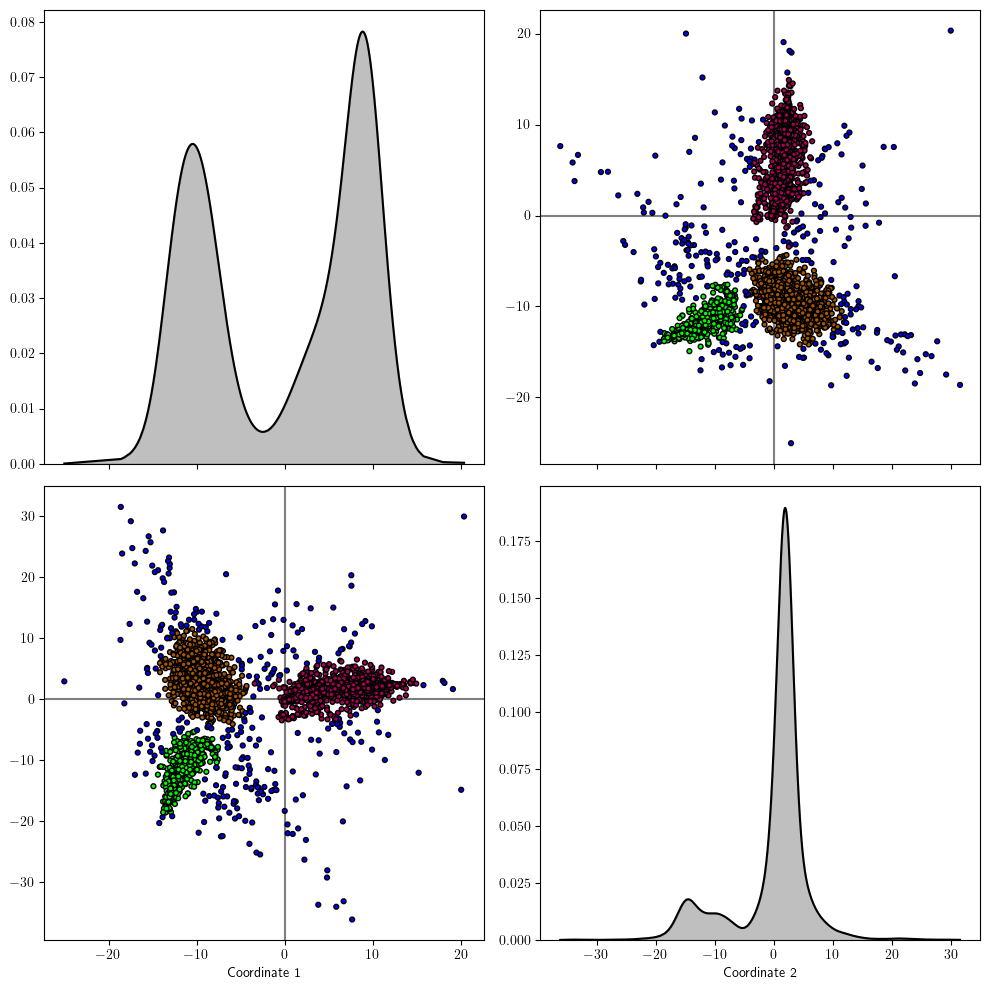

In [6]:
from collections import Counter

min_cluster_size = min(min_cluster_size_list[maximum_CH_index], min_cluster_size_list[minimum_DB_index])

print("Size for minimum cluster: ", min_cluster_size)
HDBSCAN_Out = HDBSCAN(min_cluster_size = min_cluster_size).fit(TEC_ClusterSeries.Xc_TS)
print(Counter(HDBSCAN_Out.labels_))
OutliersOrNot = np.where(HDBSCAN_Out.labels_ == -1, 1, 0)

TEC_ClusterSeries.VisualizeClustering(Labels = HDBSCAN_Out.labels_)

## SMACOF solution without outliers given by DBSCAN

In [7]:
def RemoveSameRowsAndColumns(A:np.ndarray, index) -> np.ndarray:
    return np.delete(np.delete(A, index, 0), index, 1)

In [8]:
IndexOutliers = np.argwhere(OutliersOrNot == 1)
IndexNotOutliers = np.argwhere(OutliersOrNot == 0)

print("Number of outliers: ", IndexOutliers.size)
print("Percentage of outlier: ", 100*IndexOutliers.size/TEC_ClusterSeries.Xc_TS.shape[0])

PTEX_red_dissim = RemoveSameRowsAndColumns(PTEX_dissim, IndexOutliers)
PTEX_red_dissim.shape

Number of outliers:  299
Percentage of outlier:  6.890988707075363


(4040, 4040)

SMACOF-Dissim with 2 components has a stress value of 0.085826


0.08582564868522057

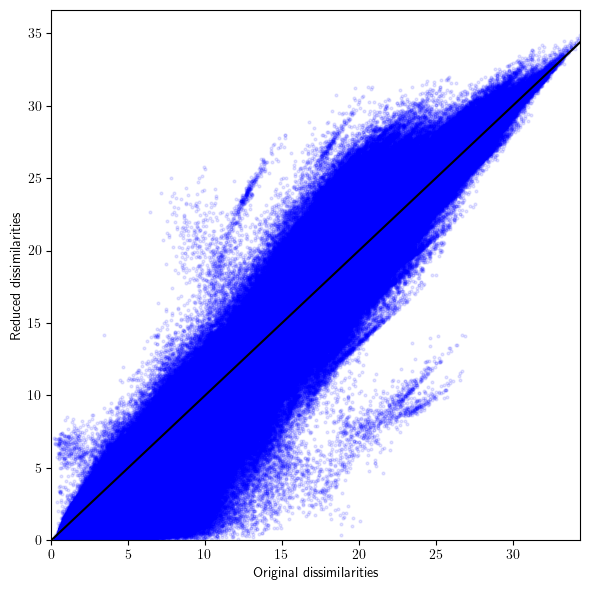

In [9]:
TEC_ClusterSeriesRed = ClusterVTECDataMDS(dissimilarity = PTEX_red_dissim)
TEC_ClusterSeriesRed.ComputeMDS(num_comps_mds = 2, method = "SMACOF-Dissim")

--Scores with K-Means clustering--
SH coefficient = 0.7535412480290548
CH index = 19110.28113306612
DB index = 0.36986880314851667
--Total series for every cluster--
0 -> 541
1 -> 1127
2 -> 2372


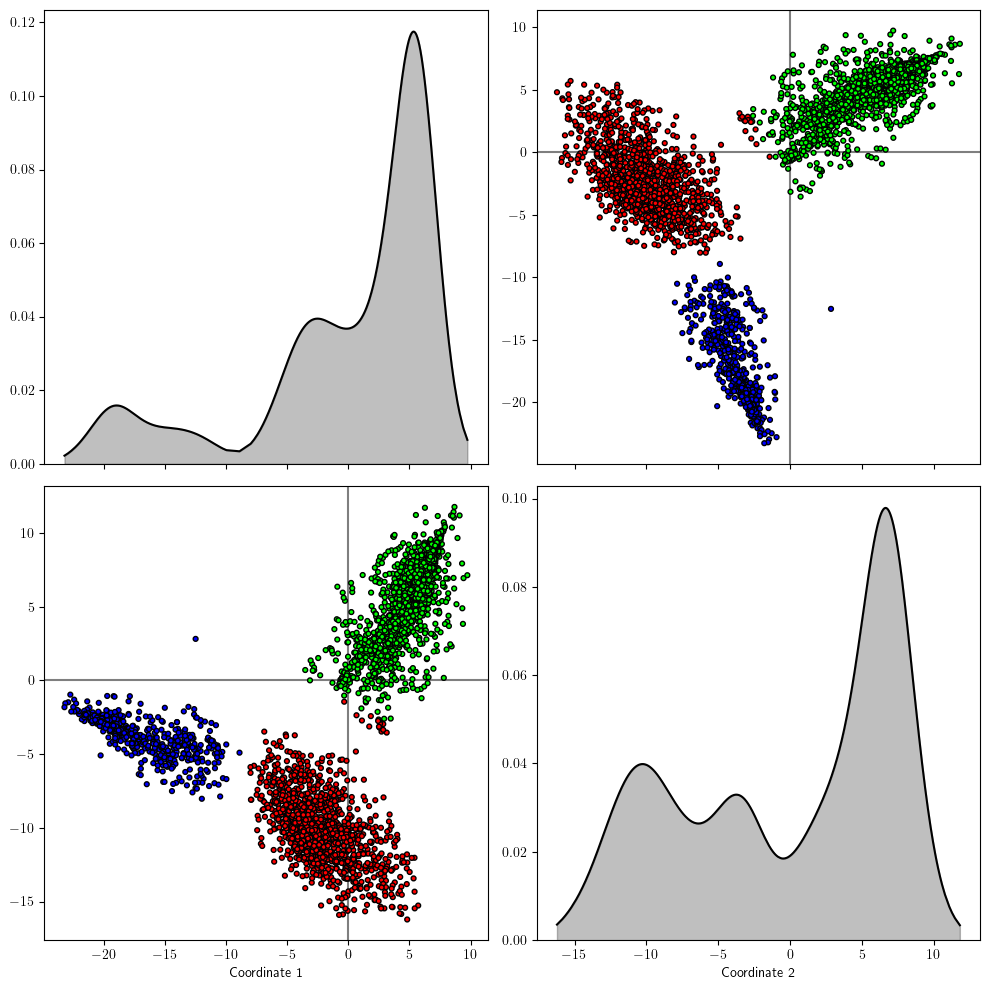

In [10]:
TEC_ClusterSeriesRed.ClusterTSVectors(num_clusters = 3, cluster_method = "K-Means")
TEC_ClusterSeriesRed.VisualizeClustering()

--Scores with GaussianMix clustering--
SH coefficient = 0.7536888419449506
CH index = 18932.01156807343
DB index = 0.366264003821964
--Total series for every cluster--
0 -> 2386
1 -> 1116
2 -> 538


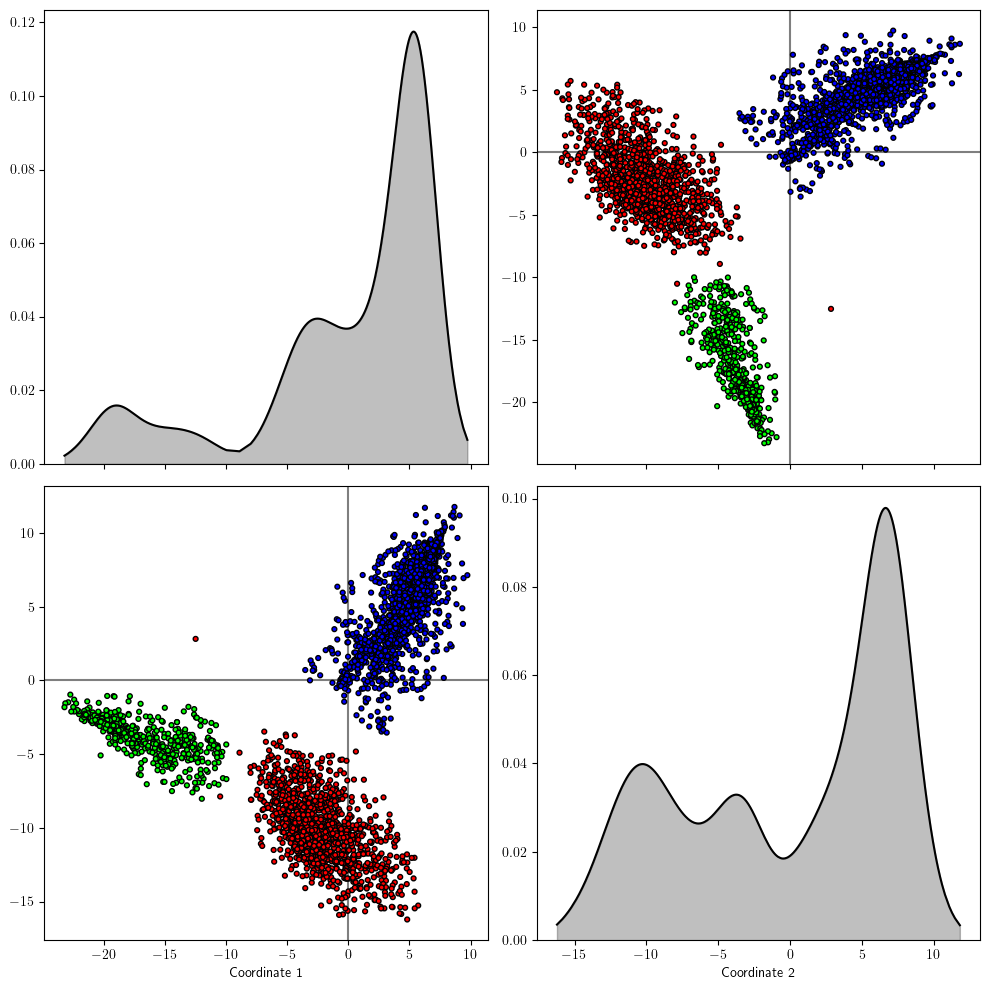

In [11]:
TEC_ClusterSeriesRed.ClusterTSVectors(num_clusters = 3, cluster_method = "Gaussian")
TEC_ClusterSeriesRed.VisualizeClustering()

## Save outliers status for all TEC series

In [12]:
CompleteLabels = np.zeros(PTEX_dissim.shape[0], dtype = int)

CompleteLabels[IndexOutliers] = -1
CompleteLabels[IndexNotOutliers] = TEC_ClusterSeriesRed.Xc_Labels.reshape(PTEX_red_dissim.shape[0], 1)

In [13]:
with open("./data/PTEX_Outliers.dat", "+w") as OutlierOuts:
    for n, label in enumerate(CompleteLabels):
        OutlierOuts.write(f"{n}, {label}\n")